In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from typing import List, Dict, Callable, Tuple
from dataclasses import dataclass
from enum import Enum
import time
from collections import defaultdict

class ReasoningStrategy(Enum):
    DIRECT = "direct"
    CHAIN_OF_THOUGHT = "chain_of_thought"
    REACT = "react"
    REFLEXION = "reflexion"

@dataclass
class AgentResponse:
    answer: str
    steps: int
    time_taken: float
    tool_calls: int
    confidence: float

class BaseAgent:
    def __init__(self, strategy: ReasoningStrategy):
        self.strategy = strategy
        self.tool_count = 0

    def solve(self, problem: str) -> AgentResponse:
        start_time = time.time()
        if self.strategy == ReasoningStrategy.DIRECT:
            answer, steps, tools = self._direct_solve(problem)
        elif self.strategy == ReasoningStrategy.CHAIN_OF_THOUGHT:
            answer, steps, tools = self._cot_solve(problem)
        elif self.strategy == ReasoningStrategy.REACT:
            answer, steps, tools = self._react_solve(problem)
        else:
            answer, steps, tools = self._reflexion_solve(problem)
        time_taken = time.time() - start_time
        confidence = self._calculate_confidence(problem, answer)
        return AgentResponse(answer, steps, time_taken, tools, confidence)

In [3]:
    def _direct_solve(self, problem: str) -> Tuple[str, int, int]:
        answer = self._compute_answer(problem)
        return answer, 1, 0

    def _cot_solve(self, problem: str) -> Tuple[str, int, int]:
        steps = 3 + len(problem.split()) // 5
        for i in range(steps):
            _ = self._reason_step(problem, i)
        answer = self._compute_answer(problem)
        return answer, steps, 0

    def _react_solve(self, problem: str) -> Tuple[str, int, int]:
        steps = 4
        tool_calls = 2
        for i in range(steps):
            _ = self._reason_step(problem, i)
            if i % 2 == 0:
                self._use_tool(problem)
        answer = self._compute_answer(problem)
        return answer, steps, tool_calls

    def _reflexion_solve(self, problem: str) -> Tuple[str, int, int]:
        steps = 6
        tool_calls = 1
        initial_answer = self._compute_answer(problem)
        reflection = self._reflect(problem, initial_answer)
        answer = self._refine(problem, initial_answer, reflection)
        return answer, steps, tool_calls

    def _reason_step(self, problem: str, step: int) -> str:
        return f"Analyzing aspect {step+1}"

    def _use_tool(self, problem: str):
        self.tool_count += 1
        time.sleep(0.001)

    def _compute_answer(self, problem: str) -> str:
        return f"Solution_{hash(problem) % 100}"

    def _reflect(self, problem: str, answer: str) -> str:
        return "Reflection on approach"

    def _refine(self, problem: str, answer: str, reflection: str) -> str:
        return f"Refined_{answer}"

    def _calculate_confidence(self, problem: str, answer: str) -> float:
        base_confidence = 0.7
        strategy_bonus = {
            ReasoningStrategy.DIRECT: 0.0,
            ReasoningStrategy.CHAIN_OF_THOUGHT: 0.1,
            ReasoningStrategy.REACT: 0.15,
            ReasoningStrategy.REFLEXION: 0.2
        }
        return min(1.0, base_confidence + strategy_bonus[self.strategy] + np.random.uniform(-0.1, 0.1))

In [4]:
class BenchmarkTask:
    def __init__(self, name: str, difficulty: float, ground_truth: str):
        self.name = name
        self.difficulty = difficulty
        self.ground_truth = ground_truth

    def evaluate(self, response: AgentResponse) -> Dict[str, float]:
        accuracy = response.confidence * (1 - self.difficulty * 0.3)
        return {
            'accuracy': accuracy,
            'efficiency': 1.0 / (response.steps + 1),
            'latency': response.time_taken,
            'tool_efficiency': 1.0 / (response.tool_calls + 1)
        }

class BenchmarkSuite:
    def __init__(self):
        self.tasks = self._create_tasks()

    def _create_tasks(self) -> List[BenchmarkTask]:
        tasks = []
        task_types = [
            ("Math_Problem", 0.3),
            ("Logic_Puzzle", 0.5),
            ("Code_Debug", 0.6),
            ("Complex_Reasoning", 0.8),
            ("Multi_Step_Planning", 0.7)
        ]
        for i, (task_type, difficulty) in enumerate(task_types):
            for j in range(3):
                task = BenchmarkTask(
                    name=f"{task_type}_{j+1}",
                    difficulty=difficulty + np.random.uniform(-0.1, 0.1),
                    ground_truth=f"GT_{i}_{j}"
                )
                tasks.append(task)
        return tasks

    def run_benchmark(self, agents: List[BaseAgent]) -> pd.DataFrame:
        results = []
        for agent in agents:
            for task in self.tasks:
                response = agent.solve(task.name)
                metrics = task.evaluate(response)
                results.append({
                    'strategy': agent.strategy.value,
                    'task': task.name,
                    'difficulty': task.difficulty,
                    'accuracy': metrics['accuracy'],
                    'efficiency': metrics['efficiency'],
                    'latency': metrics['latency'],
                    'tool_efficiency': metrics['tool_efficiency'],
                    'steps': response.steps,
                    'tool_calls': response.tool_calls
                })
        return pd.DataFrame(results)

In [5]:
def analyze_results(df: pd.DataFrame):
    agg_metrics = df.groupby('strategy').agg({
        'accuracy': ['mean', 'std'],
        'efficiency': ['mean', 'std'],
        'latency': ['mean', 'std'],
        'steps': 'mean',
        'tool_calls': 'mean'
    }).round(3)
    print(agg_metrics)

    diff_bins = pd.cut(df['difficulty'], bins=3, labels=['Easy', 'Medium', 'Hard'])
    diff_analysis = df.groupby(['strategy', diff_bins])['accuracy'].mean().unstack()
    print(diff_analysis.round(3))

    tradeoff = df.groupby('strategy').agg({
        'accuracy': 'mean',
        'steps': 'mean',
        'latency': 'mean'
    })
    tradeoff['score'] = (tradeoff['accuracy'] / (tradeoff['steps'] * tradeoff['latency'])).round(3)
    print(tradeoff.round(3))

def visualize_results(df: pd.DataFrame):
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    sns.barplot(data=df, x='strategy', y='accuracy', ax=axes[0, 0], errorbar='sd')
    axes[0, 0].set_title('Accuracy by Strategy')
    axes[0, 0].tick_params(axis='x', rotation=45)

    for strategy in df['strategy'].unique():
        strategy_df = df[df['strategy'] == strategy]
        axes[0, 1].scatter(strategy_df['steps'], strategy_df['accuracy'], label=strategy, alpha=0.6, s=50)
    axes[0, 1].set_title('Steps vs Accuracy')
    axes[0, 1].legend()

    difficulty_bins = pd.cut(df['difficulty'], bins=3, labels=['Easy', 'Medium', 'Hard'])
    df_plot = df.copy()
    df_plot['difficulty_bin'] = difficulty_bins
    sns.boxplot(data=df_plot, x='difficulty_bin', y='accuracy', hue='strategy', ax=axes[1, 0])
    axes[1, 0].set_title('Performance vs Difficulty')

    scores = df.groupby('strategy').apply(
        lambda x: x['accuracy'].mean() / (x['steps'].mean() * x['latency'].mean())
    ).sort_values()
    axes[1, 1].barh(range(len(scores)), scores.values)
    axes[1, 1].set_yticks(range(len(scores)))
    axes[1, 1].set_yticklabels(scores.index)
    axes[1, 1].set_title('Overall Efficiency Score')

    plt.tight_layout()
    plt.show()

AGENTIC COMPONENTS BENCHMARKING TUTORIAL
Benchmarking direct...
Benchmarking chain_of_thought...
Benchmarking react...
Benchmarking reflexion...

AGGREGATE METRICS BY STRATEGY
                 accuracy        efficiency      latency      steps tool_calls
                     mean    std       mean  std    mean  std  mean       mean
strategy                                                                      
chain_of_thought    0.677  0.058      0.250  0.0   0.000  0.0   3.0        0.0
direct              0.592  0.073      0.500  0.0   0.000  0.0   1.0        0.0
react               0.706  0.077      0.200  0.0   0.002  0.0   4.0        2.0
reflexion           0.745  0.071      0.143  0.0   0.000  0.0   6.0        1.0

PERFORMANCE VS DIFFICULTY
difficulty         Easy  Medium   Hard
strategy                              
chain_of_thought  0.750   0.695  0.640
direct            0.654   0.653  0.538
react             0.802   0.712  0.668
reflexion         0.859   0.724  0.714

EFFICIENC

/tmp/ipython-input-844555872.py:224: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  diff_analysis = df.groupby(['strategy', diff_bins])['accuracy'].mean().unstack()
/tmp/ipython-input-844555872.py:269: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  scores = df.groupby('strategy').apply(


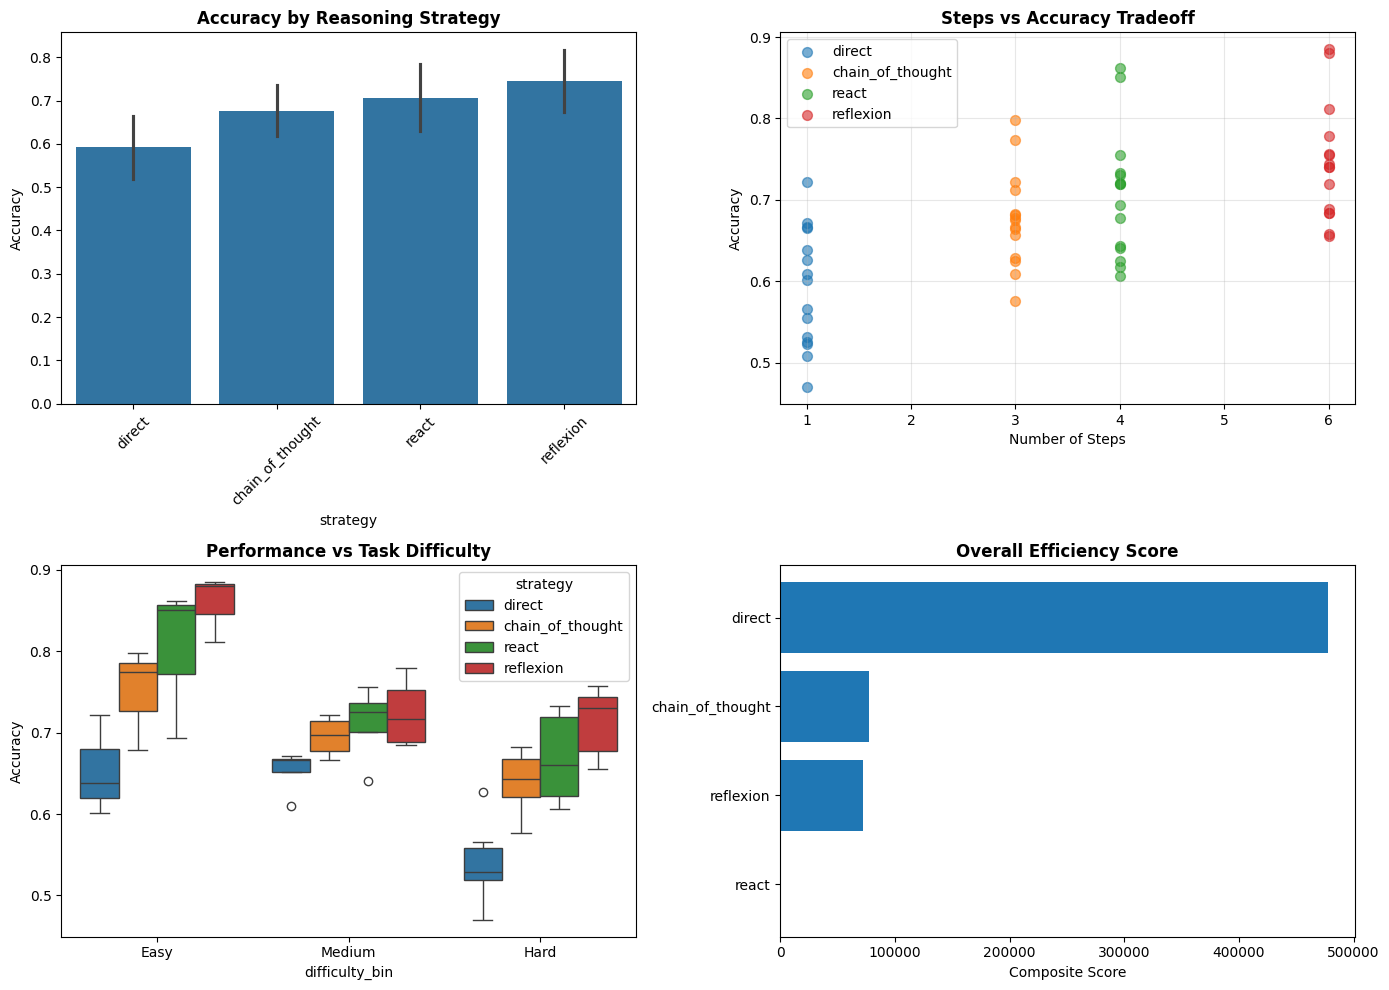


KEY FINDINGS
1. More sophisticated reasoning strategies (ReAct, Reflexion)
   achieve higher accuracy but require more computational steps
2. Chain-of-thought provides good balance between accuracy and efficiency
3. Direct strategies are fastest but less reliable on complex tasks
4. Performance degrades across all strategies on harder tasks,
   but advanced strategies degrade more gracefully


In [7]:
if __name__ == "__main__":
    agents = [
        BaseAgent(ReasoningStrategy.DIRECT),
        BaseAgent(ReasoningStrategy.CHAIN_OF_THOUGHT),
        BaseAgent(ReasoningStrategy.REACT),
        BaseAgent(ReasoningStrategy.REFLEXION)
    ]

    suite = BenchmarkSuite()
    results_df = suite.run_benchmark(agents)

    analyze_results(results_df)
    visualize_results(results_df)

    print("1. Advanced strategies achieve higher accuracy but require more steps")
    print("2. Chain-of-thought balances accuracy and efficiency")
    print("3. Direct is fastest but less reliable on hard tasks")
    print("4. All strategies degrade on harder tasks but advanced ones degrade slowly")